In [ ]:
! pip install pyriemann

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyriemann: filename=pyriemann-0.5-py2.py3-none-any.whl size=107752 sha256=ae73c02533f9b809e795e90420807afc75aa947e090d28ac8fb7453cfc088072
  Stored in directory: /root/.cache/pip/wheels/84/86/79/622e9c1dc933dc088e287ebfaac5aa9bdc6a38a9db193ce1f1
Successfully built pyriemann


In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np

import time

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.manifold import TSNE
from numpy import reshape

from pyriemann.estimation import Covariances
from pyriemann.utils.mean import mean_covariance
from pyriemann.utils.covariance import covariances
from pyriemann.utils.geodesic import geodesic_riemann
from pyriemann.embedding import SpectralEmbedding
from pyriemann.datasets.simulated import make_classification_transfer
from pyriemann.transfer import decode_domains

from scipy.linalg import sqrtm, inv
from numpy import iscomplexobj, real, any, isfinite

from tqdm import tqdm

from time import time


# Euclidean alignment transformation

In [ ]:
def euclidean_alignment(cov, y=None):

    r = mean_covariance(cov, metric='euclid')

    compare = np.allclose(r, np.identity(r.shape[0]))

    if not compare:

        if iscomplexobj(r):
            print("covariance matrix problem")
        if iscomplexobj(sqrtm(r)):
            print("covariance matrix problem sqrt")

        r_op = inv(sqrtm(r))

        if iscomplexobj(r_op):
            print("WARNING! Covariance matrix was not SPD somehow. " +
                  "Can be caused by running ICA-EOG rejection, if " +
                  "not, check data!!")
            r_op = real(r_op).astype(np.float64)
        elif not any(isfinite(r_op)):
            print("WARNING! Not finite values in R Matrix")

        result = r_op @ cov @ r_op

    else:
        print("Already aligned!")
        result = cov
        r_op = 0

    return result, r_op

def split_runs_EA(X,len_run):
  X_aux = []
  m = len_run
  n = X.shape[0]
  ref = []
  for k in range(int(n/m)):
    run = X[k*m:(k+1)*m,:,:]
    run_EA,r = euclidean_alignment(run)
    ref.append(r)
    X_aux.append(run_EA)
  X_EA = np.concatenate(X_aux, dtype=object)
  return X_EA, r


# Generate covariance matrices and align

Using as basis: https://pyriemann.readthedocs.io/en/latest/auto_examples/transfer/plot_rpa_steps.html#sphx-glr-auto-examples-transfer-plot-rpa-steps-py

In [ ]:
seed = 66
len_run = 480

# create source and target datasets
n_matrices = 240
# create source and target datasets
# y_enc is y+domain info
X_enc, y_enc = make_classification_transfer(
    n_matrices=n_matrices,
    class_sep=3.0,
    class_disp=0.5,
    domain_sep=5.0,
    theta=np.pi/4,
    random_state=seed
)


# generate dataset
X_org, y, domain = decode_domains(X_enc, y_enc)

# instantiate object for doing spectral embeddings
emb = SpectralEmbedding(n_components=2, metric='riemann')

# create dict to store the embedding after each step of RPA
embedded_points = {}

# embed the original source and target datasets
points = np.concatenate([X_org, np.eye(2)[np.newaxis, :, :]])  # stack the identity
embedded_points['origin'] = emb.fit_transform(X_org)

X_EA, refs = split_runs_EA(X_org,len_run)
X_EA = X_EA.astype('float64')
#points = np.concatenate([X_EA, np.eye(2)[None, :, :]])  # stack the identity
#embedded_points['ea'] = emb.fit_transform(points)


points = np.concatenate([X_org, X_EA, np.eye(2)[None, :, :]])
S = emb.fit_transform(points)
S = S - S[-1]
embedded_points['origin'] = S[:4*n_matrices]
embedded_points['ea'] = S[4*n_matrices:-1]

Already aligned!


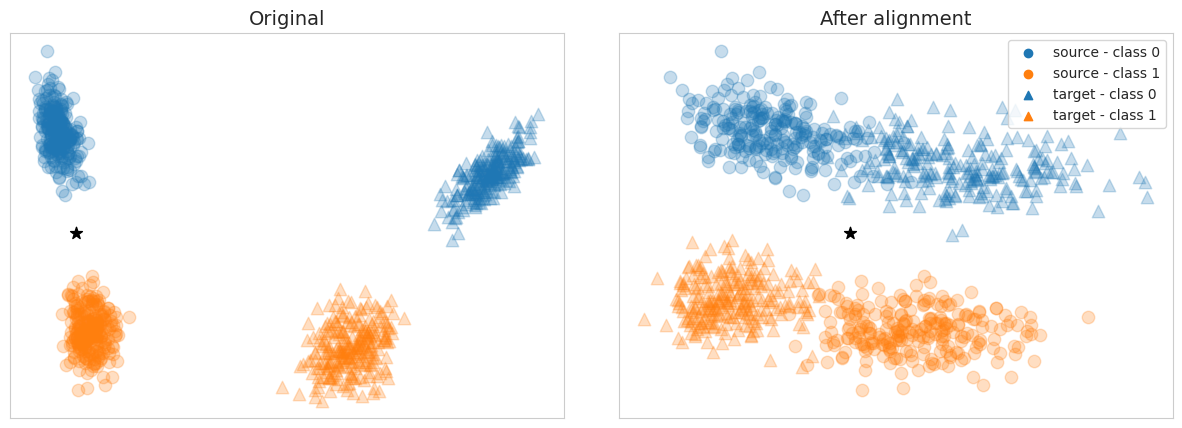

In [ ]:
sns.set_style("whitegrid")
sns.color_palette("dark")

fig, ax = plt.subplots(figsize=(15, 5), ncols=2, sharey=True)
plt.subplots_adjust(wspace=0.10)
steps = ['origin', 'ea', ]
titles = ['Original', 'After alignment']
for axi, step, title in zip(ax, steps, titles):
    S_step = embedded_points[step]
    S_source = S_step[domain == 'source_domain']
    y_source = y[domain == 'source_domain']
    S_target = S_step[domain == 'target_domain']
    y_target = y[domain == 'target_domain']
    axi.scatter(
        S_source[y_source == '1'][:, 0],
        S_source[y_source == '1'][:, 1],
        c='C0', s=80, alpha=0.25)
    axi.scatter(
        S_source[y_source == '2'][:, 0],
        S_source[y_source == '2'][:, 1],
        c='C1', s=80, alpha=0.25)
    axi.scatter(
        S_target[y_target == '1'][:, 0],
        S_target[y_target == '1'][:, 1],
        c='C0', s=80, alpha=0.25, marker="^")
    axi.scatter(
        S_target[y_target == '2'][:, 0],
        S_target[y_target == '2'][:, 1],
        c='C1', s=80, alpha=0.25, marker="^")
    axi.scatter(S[-1, 0], S[-1, 1], c='k', s=80, marker="*")
    #axi.set_xlim(-0.5, 2)
    #axi.set_ylim(-1.3, 1)
    axi.set_xticks([])
    axi.set_yticks([])
    axi.grid(True)
    axi.set_title(title, fontsize=14)
#fig.axes.get_yaxis().set_visible(False)
ax[1].scatter([], [], c="C0", label="source - class 0")
ax[1].scatter([], [], c="C1", label="source - class 1")
ax[1].scatter([], [], marker="^", c="C0", label="target - class 0")
ax[1].scatter([], [], marker="^", c="C1", label="target - class 1")
ax[1].legend(loc="best")

fig.savefig(f"cov_plot_EA.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.show()